In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd

In [158]:
X_train = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')

In [159]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# First Attempt at RNN

In [161]:
X_train.columns

Index(['sequence', 'name_normalized', 'assists_lag_1', 'bonus_lag_1',
       'bps_lag_1', 'clean_sheets_lag_1', 'creativity_lag_1',
       'goals_conceded_lag_1', 'goals_scored_lag_1', 'ict_index_lag_1',
       'influence_lag_1', 'minutes_lag_1', 'own_goals_lag_1',
       'penalties_missed_lag_1', 'penalties_saved_lag_1', 'red_cards_lag_1',
       'saves_lag_1', 'selected_lag_1', 'player_team_score_lag_1',
       'opp_team_score_lag_1', 'threat_lag_1', 'total_points_lag_1',
       'value_lag_1', 'yellow_cards_lag_1', 'assists_lag_3', 'bonus_lag_3',
       'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3',
       'goals_conceded_lag_3', 'goals_scored_lag_3', 'ict_index_lag_3',
       'influence_lag_3', 'minutes_lag_3', 'own_goals_lag_3',
       'penalties_missed_lag_3', 'penalties_saved_lag_3', 'red_cards_lag_3',
       'saves_lag_3', 'selected_lag_3', 'player_team_score_lag_3',
       'opp_team_score_lag_3', 'threat_lag_3', 'total_points_lag_3',
       'value_lag_3', 'yellow_cards_

In [160]:
X_train.head()

,sequence,name_normalized,assists_lag_1,bonus_lag_1,bps_lag_1,clean_sheets_lag_1,creativity_lag_1,goals_conceded_lag_1,goals_scored_lag_1,ict_index_lag_1,...,total_points_lag_5,value_lag_5,yellow_cards_lag_5,season_mapping,player_team_name_mapping,opp_team_name_mapping,opp_diff_ind_mapping,position_mapping,gw_mapping,was_home_mapping
0,1,aaron cresswell,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,...,-0.752585,-3.373454,-0.430582,1,1,1,1,1,1,1
1,2,aaron cresswell,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,...,-0.752585,0.329490,-0.430582,1,1,2,2,1,2,2
2,3,aaron cresswell,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,...,-0.752585,0.329490,-0.430582,1,1,3,1,1,3,1
3,4,aaron cresswell,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,...,-0.752585,0.307048,-0.430582,1,1,4,3,1,4,2
4,5,aaron cresswell,-0.184964,-0.215403,0.433488,-0.337274,2.172931,0.540089,-0.188555,0.665147,...,-0.611039,0.278995,1.677694,1,1,5,3,1,5,1


In [124]:


# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

In [125]:
# # Preparing the 3d shape for RNN
# def make_three_dim_input(X, sequence_length=10):
#     # sequence_length 10 time steps per sequence is the default
#     features = X_train.columns.difference(['player_id', 'sequence'])  
#     sequences = []

#     # Group by player_id and create sequences
#     for player_id, group in X.groupby('player_id'):
#         # Ensure the group is sorted if needed
#         group = group.sort_values(by='sequence')
        
#         # Creating sequences
#         for start_idx in range(len(group) - sequence_length + 1):
#             end_idx = start_idx + sequence_length
#             sequence = group.iloc[start_idx:end_idx][features].values  # Extract the features for the sequence
#             sequences.append(sequence)

#     # Convert to 3D array
#     return np.array(sequences)  # Shape: [num_sequences, sequence_length, num_features]
# X_train_sequences = make_three_dim_input(X_train)
# X_val_sequences = make_three_dim_input(X_val)

## Sequence Slicing

In [126]:
# Example function to create sequences and align targets
def create_sequences_and_targets(X, Y, sequence_length):
    sequences = []
    targets = []

    for player_id, group in X.groupby('player_id'):
        player_targets = Y[Y['player_id'] == player_id]['total_points']

        for start_idx in range(len(group) - sequence_length + 1):
            end_idx = start_idx + sequence_length
            sequences.append(group.iloc[start_idx:end_idx].values)
            targets.append(player_targets.iloc[end_idx - 1])  # Aligning target

    return np.array(sequences), np.array(targets)

# Create sequences and aligned targets
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 10)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 10)


## Test Model

In [142]:
# LSTM Base model

# Assuming each sequence has a shape of (sequence_length, num_features)
sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]

model = Sequential()
# Adding an LSTM layer
# 'return_sequences=True' is needed if you stack more LSTM layers.
model.add(LSTM(10, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )

# Optionally add more LSTM or Dense layers
# model.add(LSTM(50, return_sequences=False))

# Adding a Dropout layer for regularization
model.add(Dropout(0.5, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))


# model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics='mse')



# model.compile(
#     optimizer=optimizer,
#     loss='mse',
#     metrics=['accuracy']
#     )


In [143]:
X_train.columns

Index(['sequence', 'assists_lag_1', 'bonus_lag_1', 'bps_lag_1',
       'clean_sheets_lag_1', 'creativity_lag_1', 'goals_conceded_lag_1',
       'goals_scored_lag_1', 'ict_index_lag_1', 'influence_lag_1',
       'minutes_lag_1', 'own_goals_lag_1', 'penalties_missed_lag_1',
       'penalties_saved_lag_1', 'red_cards_lag_1', 'saves_lag_1',
       'selected_lag_1', 'player_team_score_lag_1', 'opp_team_score_lag_1',
       'threat_lag_1', 'total_points_lag_1', 'value_lag_1',
       'yellow_cards_lag_1', 'assists_lag_3', 'bonus_lag_3', 'bps_lag_3',
       'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3',
       'goals_scored_lag_3', 'ict_index_lag_3', 'influence_lag_3',
       'minutes_lag_3', 'own_goals_lag_3', 'penalties_missed_lag_3',
       'penalties_saved_lag_3', 'red_cards_lag_3', 'saves_lag_3',
       'selected_lag_3', 'player_team_score_lag_3', 'opp_team_score_lag_3',
       'threat_lag_3', 'total_points_lag_3', 'value_lag_3',
       'yellow_cards_lag_3', 'assists_la

In [144]:
X_train_sequences.shape

(59155, 10, 75)

In [146]:
# Assuming Y_train contains the target variable corresponding to X_train_sequences
history = model.fit(X_train_sequences, Y_train_aligned, epochs=30, batch_size=16, 
                    validation_data = (X_val_sequences, Y_val_aligned))


Epoch 1/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1557 - mse: 5.1557 - val_loss: 4.6333 - val_mse: 4.6333
Epoch 2/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1566 - mse: 5.1566 - val_loss: 4.5590 - val_mse: 4.5590
Epoch 3/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1428 - mse: 5.1428 - val_loss: 4.6748 - val_mse: 4.6748
Epoch 4/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1268 - mse: 5.1268 - val_loss: 4.5634 - val_mse: 4.5634
Epoch 5/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1346 - mse: 5.1346 - val_loss: 4.6082 - val_mse: 4.6082
Epoch 6/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1575 - mse: 5.1575 - val_loss: 4.5507 - val_mse: 4.5507
Epoch 7/30
3698/3698 [==============================] - 7s 2ms/step - loss: 5.1580 - mse: 5.1580 - val_loss: 4.5763 - val_mse: 4.5763
Epoch 8/30
3698/3698 [==============================] - 7s 2ms

In [ ]:
# Plotting loss and accuracy for training and validation sets
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.set_title('Loss by Epoch')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['mse'], '-o', label='Train MSE.')
ax.plot(x_arr, hist['val_mse'], '--<', label='Validation MSE.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('MSE', size=12)
# ax.set_ylim(0,1)
ax.set_title('MSE by Epoch')
plt.show()

## Creating Repeatable Function

In [154]:
# Function to reduce features

COL_BASE = ['player_id', 'sequence']
def create_input(cols, sequence_length):
    train_input = X_train[COL_BASE + cols]
    val_input = X_val[COL_BASE + cols]
    train_seq, y_train_seq = create_sequences_and_targets(train_input, Y_train, sequence_length)
    val_seq, y_val_seq = create_sequences_and_targets(val_input, Y_val, sequence_length)
    return train_seq, y_train_seq, val_seq, y_val_seq

def compile_and_run(train_seq,
                y_train_seq,
                val_seq,
                y_val_seq,
                **kwargs
               ):
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = Sequential()
    sequence_length = train_seq.shape[1]
    num_features = train_seq.shape[2]
    lstm_size = kwargs.get('lstm_size', 50)
    model.add(LSTM(lstm_size, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM1'
              ),
    )
    drop = kwargs.get('drop', 0.5)
    model.add(Dropout(drop, name='drop1'))
    model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))
    learning_rate = kwargs.get('learning_rate', 0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics='mae')
    print(model.summary())
    epochs = kwargs.get('epochs', 5)
    history = model.fit(train_seq, y_train_seq, epochs=epochs, batch_size=kwargs.get('batch_size', 32), 
                    validation_data = (val_seq, y_val_seq))
    return history

def plot(h):
    hist = h.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Loss', size=12)
    ax.set_title('Loss by Epoch')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['mse'], '-o', label='Train MSE.')
    ax.plot(x_arr, hist['val_mse'], '--<', label='Validation MSE.')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('MSE', size=12)
    # ax.set_ylim(0,1)
    ax.set_title('MSE by Epoch')
    plt.show()

    
def pipeline(cols, 
             lstm_size=50,
             drop=0.5,
             sequence_length=10,
             epochs=5,
             learning_rate=0.001,
             batch_size=32
            ):
    train_seq, y_train_seq, val_seq, y_val_seq = create_input(cols, sequence_length)
    _history = compile_and_run(train_seq, y_train_seq, val_seq, y_val_seq, lstm_size=lstm_size,
                               drop=drop, epochs=epochs, learning_rate=learning_rate)
    plot(_history)
    pass          

# Trying different features

In [149]:
X_train.columns

Index(['sequence', 'assists_lag_1', 'bonus_lag_1', 'bps_lag_1',
       'clean_sheets_lag_1', 'creativity_lag_1', 'goals_conceded_lag_1',
       'goals_scored_lag_1', 'ict_index_lag_1', 'influence_lag_1',
       'minutes_lag_1', 'own_goals_lag_1', 'penalties_missed_lag_1',
       'penalties_saved_lag_1', 'red_cards_lag_1', 'saves_lag_1',
       'selected_lag_1', 'player_team_score_lag_1', 'opp_team_score_lag_1',
       'threat_lag_1', 'total_points_lag_1', 'value_lag_1',
       'yellow_cards_lag_1', 'assists_lag_3', 'bonus_lag_3', 'bps_lag_3',
       'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3',
       'goals_scored_lag_3', 'ict_index_lag_3', 'influence_lag_3',
       'minutes_lag_3', 'own_goals_lag_3', 'penalties_missed_lag_3',
       'penalties_saved_lag_3', 'red_cards_lag_3', 'saves_lag_3',
       'selected_lag_3', 'player_team_score_lag_3', 'opp_team_score_lag_3',
       'threat_lag_3', 'total_points_lag_3', 'value_lag_3',
       'yellow_cards_lag_3', 'assists_la

In [150]:
all_cols = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1',
       'clean_sheets_lag_1', 'creativity_lag_1', 'goals_conceded_lag_1',
       'goals_scored_lag_1', 'ict_index_lag_1', 'influence_lag_1',
       'minutes_lag_1', 'own_goals_lag_1', 'penalties_missed_lag_1',
       'penalties_saved_lag_1', 'red_cards_lag_1', 'saves_lag_1',
       'selected_lag_1', 'player_team_score_lag_1', 'opp_team_score_lag_1',
       'threat_lag_1', 'total_points_lag_1', 'value_lag_1',
       'yellow_cards_lag_1', 'assists_lag_3', 'bonus_lag_3', 'bps_lag_3',
       'clean_sheets_lag_3', 'creativity_lag_3', 'goals_conceded_lag_3',
       'goals_scored_lag_3', 'ict_index_lag_3', 'influence_lag_3',
       'minutes_lag_3', 'own_goals_lag_3', 'penalties_missed_lag_3',
       'penalties_saved_lag_3', 'red_cards_lag_3', 'saves_lag_3',
       'selected_lag_3', 'player_team_score_lag_3', 'opp_team_score_lag_3',
       'threat_lag_3', 'total_points_lag_3', 'value_lag_3',
       'yellow_cards_lag_3', 'assists_lag_5', 'bonus_lag_5', 'bps_lag_5',
       'clean_sheets_lag_5', 'creativity_lag_5', 'goals_conceded_lag_5',
       'goals_scored_lag_5', 'ict_index_lag_5', 'influence_lag_5',
       'minutes_lag_5', 'own_goals_lag_5', 'penalties_missed_lag_5',
       'penalties_saved_lag_5', 'red_cards_lag_5', 'saves_lag_5',
       'selected_lag_5', 'player_team_score_lag_5', 'opp_team_score_lag_5',
       'threat_lag_5', 'total_points_lag_5', 'value_lag_5',
       'yellow_cards_lag_5', 'season_mapping', 'player_team_name_mapping',
       'opp_team_name_mapping', 'opp_diff_ind_mapping', 'position_mapping',
       'gw_mapping', 'was_home_mapping', ]

col_list_alpha = ['position_mapping', 'opp_diff_ind_mapping']
lag_3_min = ['minutes_lag_3', 'total_points_lag_3']
lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']
lag_3_plus = lag_3_min + ['player_team_score_lag_3', 'opp_team_score_lag_3']
lag_3_plus_norm = lag_3_plus + ['player_team_name_mapping']


# Column combination possibilities

lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

cat = ['season_mapping', 'player_team_name_mapping', 'opp_team_name_mapping',
       'opp_diff_ind_mapping', 'position_mapping', 'gw_mapping', 'was_home_mapping']

judgmental_imp = ['player_team_name_mapping', 'opp_team_name_mapping',
       'opp_diff_ind_mapping', 'position_mapping', 'was_home_mapping',
       'assists_lag_3', 'bonus_lag_3', 'goals_scored_lag_3', 'ict_index_lag_3', 
       'minutes_lag_3', 'red_cards_lag_3', 'selected_lag_3', 'player_team_score_lag_3', 
       'opp_team_score_lag_3', 'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3'] # Uses lag 3 as a default

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 10)                3440      
                                                                 
 drop1 (Dropout)             (None, 10)                0         
                                                                 
 Dense1 (Dense)              (None, 1)                 11        
                                                                 
Total params: 3451 (13.48 KB)
Trainable params: 3451 (13.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
1849/1849 [==============================] - 5s 2ms/step - loss: 6.1478 - mse: 6.1478 - val_loss: 4.8411 - val_mse: 4.8411
Epoch 2/30
1849/1849 [==============================] - 4s 2ms/step - loss: 5.3677 - mse: 5.3677 - val_loss: 4.6178 - val_mse: 4.6178
Epoch 3/30
18

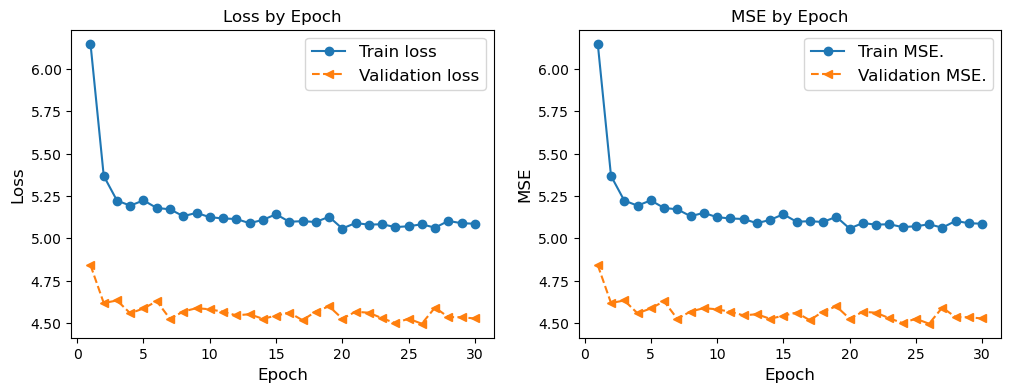

In [151]:
cols = all_cols
pipeline(all_cols, 
         lstm_size=10,
         drop=0.5,
         sequence_length=10,
         epochs=30,
         learning_rate=0.001,
         batch_size=1
        )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 150)               96000     
                                                                 
 drop1 (Dropout)             (None, 150)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 151       
                                                                 
Total params: 96151 (375.59 KB)
Trainable params: 96151 (375.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
2082/2082 [==============================] - 8s 3ms/step - loss: 5.5521 - mse: 5.5521 - val_loss: 5.0601 - val_mse: 5.0601
Epoch 2/5
2082/2082 [==============================] - 7s 3ms/step - loss: 5.3053 - mse: 5.3053 - val_loss: 4.6869 - val_mse: 4.6869
Epoch 3/5
2

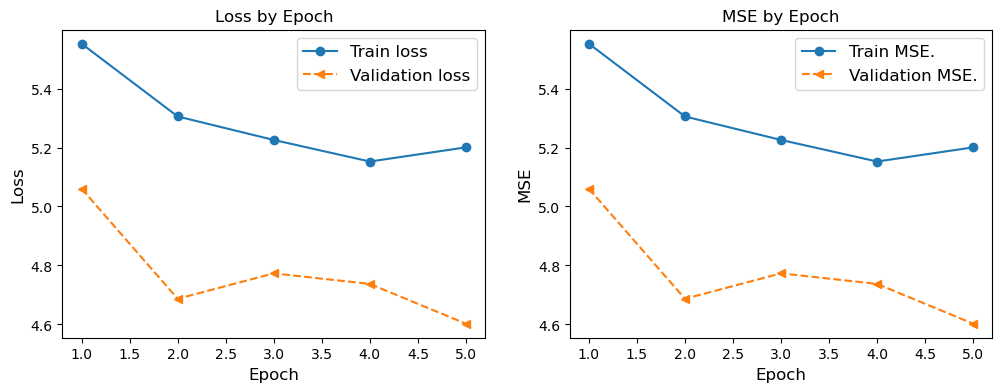

In [136]:
cols = col_list_alpha + lag_3_plus_norm
pipeline(cols, 
         lstm_size=150,
         drop=0.2,
         sequence_length=3,
         epochs=5,
         learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 150)               95400     
                                                                 
 drop1 (Dropout)             (None, 150)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 151       
                                                                 
Total params: 95551 (373.25 KB)
Trainable params: 95551 (373.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
2082/2082 [==============================] - 5s 2ms/step - loss: 5.5175 - mse: 5.5175 - val_loss: 4.8574 - val_mse: 4.8574
Epoch 2/5
2082/2082 [==============================] - 4s 2ms/step - loss: 5.3641 - mse: 5.3641 - val_loss: 4.9024 - val_mse: 4.9024
Epoch 3/5
2

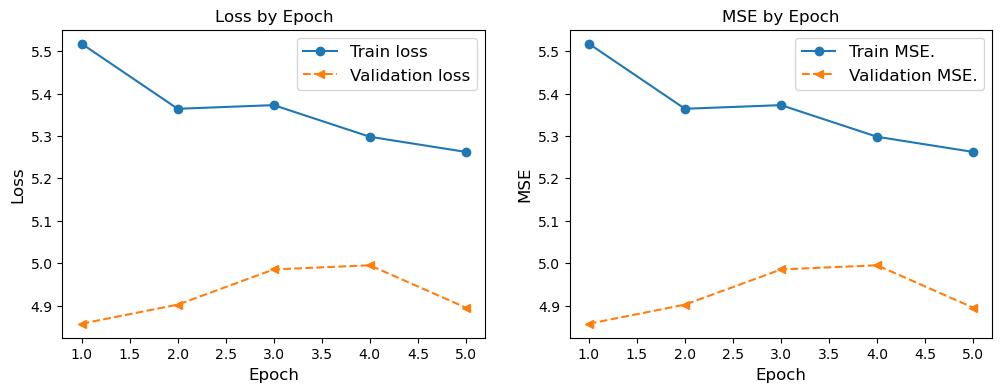

In [71]:
cols = col_list_alpha + lag_3_plus
pipeline(cols, 
         lstm_size=150,
         drop=0.2,
         sequence_length=3,
         epochs=5,
         learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 50)                11400     
                                                                 
 drop1 (Dropout)             (None, 50)                0         
                                                                 
 Dense1 (Dense)              (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
2015/2015 [==============================] - 3s 1ms/step - loss: 5.7477 - mse: 5.7477 - val_loss: 4.7791 - val_mse: 4.7791
Epoch 2/5
2015/2015 [==============================] - 3s 1ms/step - loss: 5.2048 - mse: 5.2048 - val_loss: 4.7732 - val_mse: 4.7732
Epoch 3/5
201

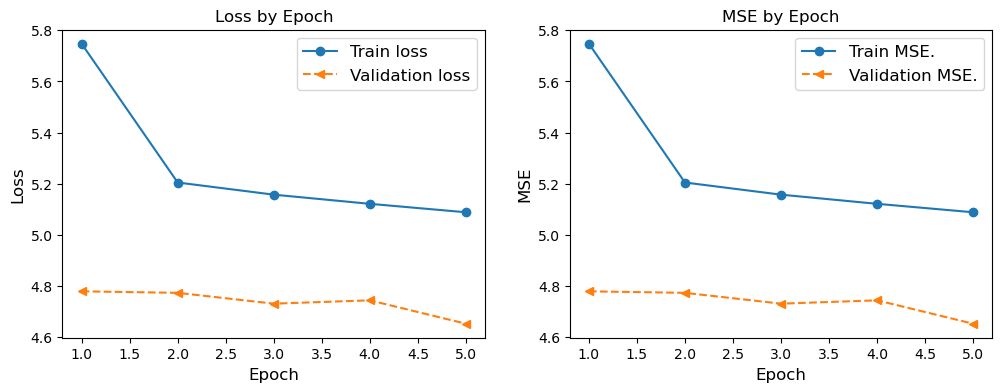

In [87]:
cols = col_list_alpha + lag_3_min
pipeline(cols, 
         lstm_size=50,
         drop=0.5,
         sequence_length=5,
         epochs=5,
         learning_rate=0.001)

# More Complex Model

In [155]:
def compile_and_run(train_seq,
                y_train_seq,
                val_seq,
                y_val_seq,
                **kwargs
               ):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = Sequential()
    sequence_length = train_seq.shape[1]
    num_features = train_seq.shape[2]
    lstm_size = kwargs.get('lstm_size', 50)
    model.add(LSTM(lstm_size, 
               return_sequences=True, 
               input_shape=(sequence_length, num_features),
               name='LSTM1'
              ),
    )
    drop = kwargs.get('drop', 0.5)
    model.add(Dropout(drop, name='drop1'))

    model.add(LSTM(lstm_size, 
               return_sequences=True, 
               input_shape=(sequence_length, num_features),
               name='LSTM2'
              ),
    )
    model.add(Dropout(drop, name='drop2'))


    model.add(LSTM(lstm_size, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM3'
              ),
    )
    model.add(Dropout(drop, name='drop3'))

    # Output Layer
    model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))
    learning_rate = kwargs.get('learning_rate', 0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics='mae')
    print(model.summary())
    epochs = kwargs.get('epochs', 5)
    history = model.fit(train_seq, y_train_seq, epochs=epochs, batch_size=32, 
                    validation_data = (val_seq, y_val_seq))
    return history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 3, 3)              948       
                                                                 
 drop1 (Dropout)             (None, 3, 3)              0         
                                                                 
 LSTM2 (LSTM)                (None, 3, 3)              84        
                                                                 
 drop2 (Dropout)             (None, 3, 3)              0         
                                                                 
 LSTM3 (LSTM)                (None, 3)                 84        
                                                                 
 drop3 (Dropout)             (None, 3)                 0         
                                                                 
 Dense1 (Dense)              (None, 1)                 4

KeyError: 'mse'

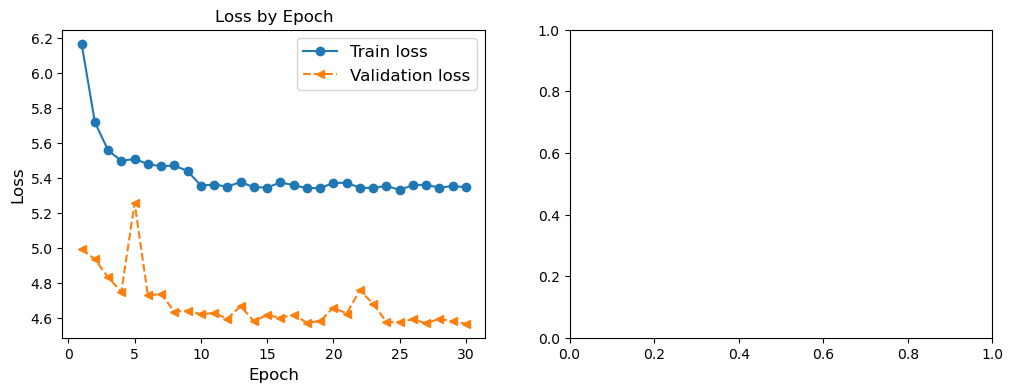

In [156]:
pipeline(all_cols, 
         lstm_size=3,
         drop=0.5,
         sequence_length=3,
         epochs=30,
         learning_rate=0.001)

In [153]:
pipeline(all_cols, 
         lstm_size=3,
         drop=0.5,
         sequence_length=3,
         epochs=5,
         learning_rate=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 3)                 948       
                                                                 
 drop1 (Dropout)             (None, 3)                 0         
                                                                 
 Dense1 (Dense)              (None, 1)                 4         
                                                                 
Total params: 952 (3.72 KB)
Trainable params: 952 (3.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
2082/2082 [==============================] - 5s 2ms/step - loss: 6.2004 - mse: 6.2004 - val_loss: 4.9489 - val_mse: 4.9489
Epoch 2/5
2057/2082 [============================>.] - ETA: 0s - loss: 5.5198 - mse: 5.5198

KeyboardInterrupt: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 3, 150)            135600    
                                                                 
 drop1 (Dropout)             (None, 3, 150)            0         
                                                                 
 LSTM2 (LSTM)                (None, 3, 150)            180600    
                                                                 
 drop2 (Dropout)             (None, 3, 150)            0         
                                                                 
 LSTM3 (LSTM)                (None, 150)               180600    
                                                                 
 drop3 (Dropout)             (None, 150)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 1

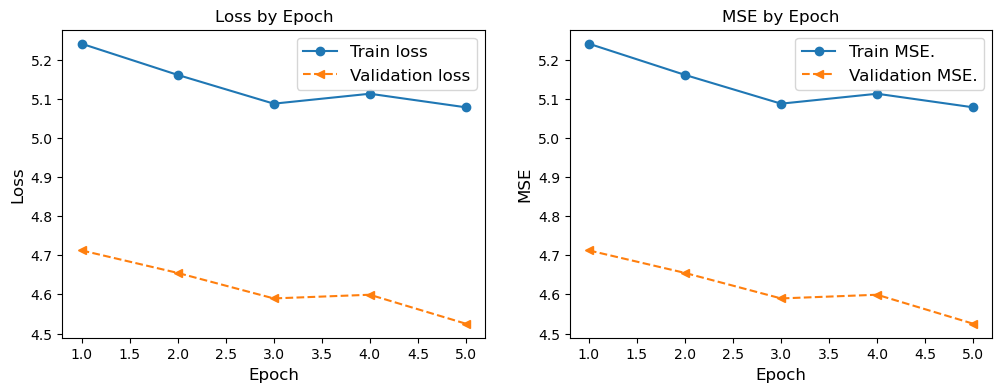

In [94]:
pipeline(all_cols, 
         lstm_size=150,
         drop=0.5,
         sequence_length=3,
         epochs=5,
         learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 5, 150)            135600    
                                                                 
 drop1 (Dropout)             (None, 5, 150)            0         
                                                                 
 LSTM2 (LSTM)                (None, 5, 150)            180600    
                                                                 
 drop2 (Dropout)             (None, 5, 150)            0         
                                                                 
 LSTM3 (LSTM)                (None, 150)               180600    
                                                                 
 drop3 (Dropout)             (None, 150)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 1

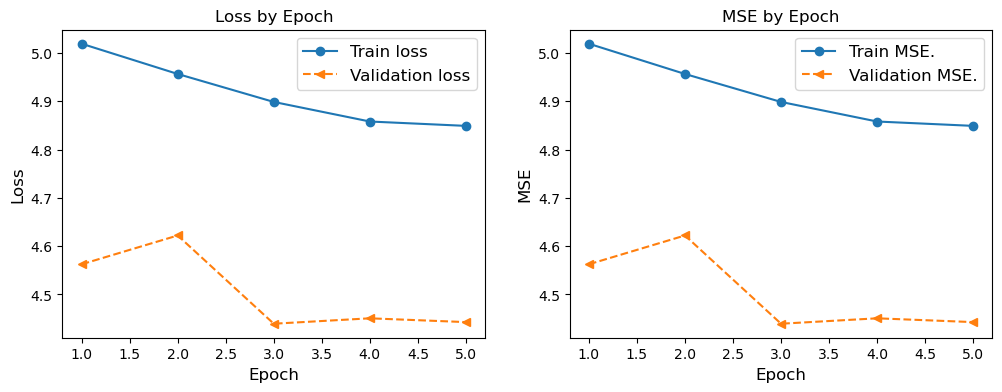

In [95]:
pipeline(all_cols, 
         lstm_size=150,
         drop=0.2,
         sequence_length=5,
         epochs=5,
         learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 3, 300)            451200    
                                                                 
 drop1 (Dropout)             (None, 3, 300)            0         
                                                                 
 LSTM2 (LSTM)                (None, 3, 300)            721200    
                                                                 
 drop2 (Dropout)             (None, 3, 300)            0         
                                                                 
 LSTM3 (LSTM)                (None, 300)               721200    
                                                                 
 drop3 (Dropout)             (None, 300)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 3

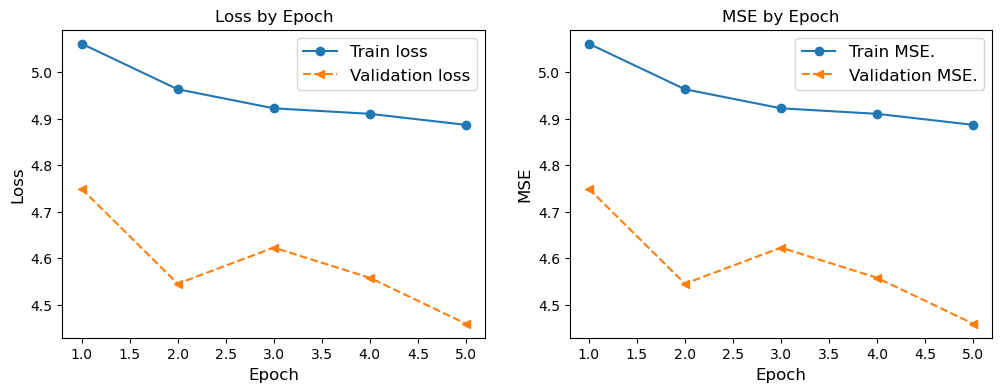

In [96]:
pipeline(all_cols, 
         lstm_size=300,
         drop=0.2,
         sequence_length=3,
         epochs=5,
         learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 5, 150)            135600    
                                                                 
 drop1 (Dropout)             (None, 5, 150)            0         
                                                                 
 LSTM2 (LSTM)                (None, 5, 150)            180600    
                                                                 
 drop2 (Dropout)             (None, 5, 150)            0         
                                                                 
 LSTM3 (LSTM)                (None, 150)               180600    
                                                                 
 drop3 (Dropout)             (None, 150)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 1

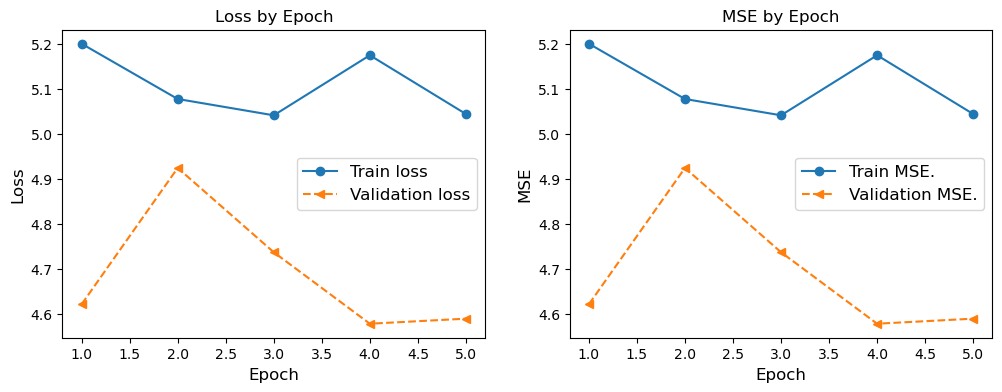

In [97]:
pipeline(all_cols, 
         lstm_size=150,
         drop=0.2,
         sequence_length=5,
         epochs=5,
         learning_rate=0.01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 5, 150)            135600    
                                                                 
 drop1 (Dropout)             (None, 5, 150)            0         
                                                                 
 LSTM2 (LSTM)                (None, 5, 150)            180600    
                                                                 
 drop2 (Dropout)             (None, 5, 150)            0         
                                                                 
 LSTM3 (LSTM)                (None, 150)               180600    
                                                                 
 drop3 (Dropout)             (None, 150)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 1

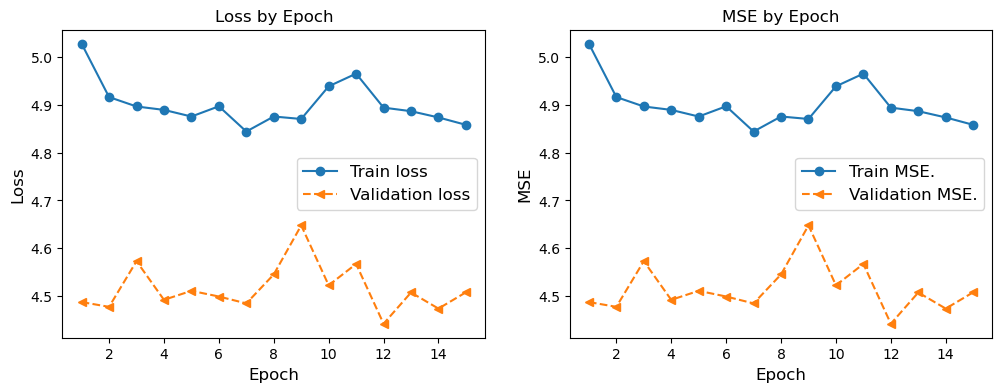

In [98]:
pipeline(all_cols, 
         lstm_size=150,
         drop=0.2,
         sequence_length=5,
         epochs=15,
         learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 5, 300)            451200    
                                                                 
 drop1 (Dropout)             (None, 5, 300)            0         
                                                                 
 LSTM2 (LSTM)                (None, 5, 300)            721200    
                                                                 
 drop2 (Dropout)             (None, 5, 300)            0         
                                                                 
 LSTM3 (LSTM)                (None, 300)               721200    
                                                                 
 drop3 (Dropout)             (None, 300)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 3

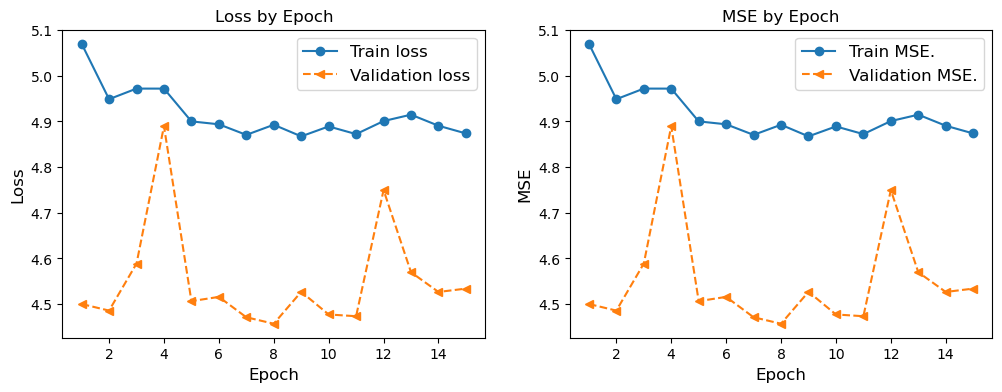

In [99]:
pipeline(all_cols, 
         lstm_size=300,
         drop=0.2,
         sequence_length=5,
         epochs=15,
         learning_rate=0.005)

In [106]:


def compile_and_run_lr(train_seq, y_train_seq, val_seq, y_val_seq, **kwargs):
    sequence_length = train_seq.shape[1]
    num_features = train_seq.shape[2]
    lstm_size = kwargs.get('lstm_size', 50)
    epochs = kwargs.get('epochs', 5)

    # Store the history of each run
    history_dict = {}

    for lr in [0.001, 0.01, 0.2, 0.25]:
        tf.keras.backend.clear_session()
        tf.random.set_seed(1234)

        model = Sequential([
            LSTM(lstm_size, return_sequences=True, input_shape=(sequence_length, num_features), name='LSTM1'),
            Dropout(kwargs.get('drop', 0.5), name='drop1'),
            LSTM(lstm_size, return_sequences=True, name='LSTM2'),
            Dropout(kwargs.get('drop', 0.5), name='drop2'),
            LSTM(lstm_size, return_sequences=False, name='LSTM3'),
            Dropout(kwargs.get('drop', 0.5), name='drop3'),
            Dense(units=1, activation='linear', name='Dense1')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

        print(f"Training model with learning rate: {lr}")
        history = model.fit(train_seq, y_train_seq, epochs=epochs, batch_size=8, 
                            validation_data=(val_seq, y_val_seq), verbose=1)

        history_dict[lr] = history.history

    return history_dict


In [107]:
def plot_learning_rates(histories):
    plt.figure(figsize=(14, 8))

    for lr, history in histories.items():
        epochs = range(1, len(history['loss']) + 1)

        # Plot training loss
        plt.plot(epochs, history['loss'], label=f'Training Loss - lr={lr}')
        
        # Plot validation loss
        plt.plot(epochs, history['val_loss'], label=f'Validation Loss - lr={lr}', linestyle='dashed')

    plt.title('Training and Validation loss for different learning rates')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [108]:
histories

In [109]:
train_seq, y_train_seq, val_seq, y_val_seq = create_input(all_cols, 3)
histories = compile_and_run(train_seq, y_train_seq, val_seq, y_val_seq, lstm_size=300, epochs=5)
plot_learning_rates(histories)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 3, 300)            451200    
                                                                 
 drop1 (Dropout)             (None, 3, 300)            0         
                                                                 
 LSTM2 (LSTM)                (None, 3, 300)            721200    
                                                                 
 drop2 (Dropout)             (None, 3, 300)            0         
                                                                 
 LSTM3 (LSTM)                (None, 300)               721200    
                                                                 
 drop3 (Dropout)             (None, 300)               0         
                                                                 
 Dense1 (Dense)              (None, 1)                 3

AttributeError: 'History' object has no attribute 'items'

<Figure size 1400x800 with 0 Axes>